<a href="https://colab.research.google.com/github/nanekeshishyan/auto_building/blob/main/auto_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install rtree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 6.1 MB/s eta 0:00:00


In [ ]:
import json
import math
import random

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from rtree import index

import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, mapping
from shapely.ops import unary_union

# Examples of territories

I have tried the automatic development algorithm on a variety of territory examples with different kinds of restrictions and different shapes, and decided to demonstrate the code on these two examples (triangular one and large one):





In [ ]:
geojson_dict_large = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {"name": "Зона застройки"},
      "geometry": {
        "type": "Polygon",
        "coordinates": [[
          [37.6000, 55.7500],
          [37.6160, 55.7500],
          [37.6170, 55.7520],
          [37.6175, 55.7570],
          [37.6120, 55.7580],
          [37.6050, 55.7570],
          [37.6000, 55.7520],
          [37.6000, 55.7500]
        ]]
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Водоем", "restriction": "no_build"},
      "geometry": {
        "type": "Polygon",
        "coordinates": [[
          [37.6110, 55.7540],
          [37.6130, 55.7540],
          [37.6130, 55.7550],
          [37.6110, 55.7550],
          [37.6110, 55.7540]
        ]]
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Лесная зона", "restriction": "no_build"},
      "geometry": {
        "type": "Polygon",
        "coordinates": [[
          [37.6050, 55.7525],
          [37.6080, 55.7525],
          [37.6080, 55.7540],
          [37.6050, 55.7540],
          [37.6050, 55.7525]
        ]]
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Дорога", "restriction": "no_build"},
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [37.6000, 55.7560],
          [37.6170, 55.7560]
        ]
      }
    }
  ]
}

# Creates a file based on the dictionary
with open('geojson_file_large', 'w') as f:
    json.dump(geojson_dict_large, f)

# Get the territory

This part of the project consists of two functions that load and visualize geo data.

**load_geojson** takes a file path and a EPSG code as parameters. It reads the GeoJSON file, converts its coordinate system to the specified EPSG code.

**plot_territory** takes the resulting GeoDataFrame as input and visualizes the territory with its restrictions and buildable area.



In [ ]:
def load_geojson(path, epsg_code=3857):
    """
    Loads the geojson file and converts it to the EPSG:3857 coordinate system (meters).
    The initial coordinate system of the file is EPSG:4326 which uses latitude and longitude in degrees.

    Args:
        path (str): path to the geojson file.
        epsg_code (int): EPSG code to convert the file to (default is meters).

    Returns:
        gpd.GeoDataFrame object.
    """
    gdf = gpd.read_file(path)

    # Converts to meters
    gdf = gdf.to_crs(epsg=epsg_code)

    return gdf

In [ ]:
gdf_large = load_geojson('geojson_file_large')
gdf_large

,name,restriction,geometry
0,Зона застройки,None,"POLYGON ((4185612.854 7508807.851, 4187393.966..."
1,Водоем,no_build,"POLYGON ((4186837.368 7509599.068, 4187060.007..."
2,Лесная зона,no_build,"POLYGON ((4186169.451 7509302.352, 4186503.41 ..."
3,Дорога,no_build,"LINESTRING (4185612.854 7509994.707, 4187505.2..."


In [ ]:
def plot_territory(gdf):
    """
    Plots the entire territory with its restrictions and buildable area.

    Args:
        gdf (gdp.GeoDataFrame): the initial area with restrictions and bulding zones.
    """
    # Creates a figure (8x8) and axes and plots the geodataframe
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, column="name", cmap="Accent_r", edgecolor="black", legend=True)
    ax.grid(True, linestyle="dashed", alpha=0.5)

    # Iterates through each row of the geodataframe, finds its centroid
    # and then places text at the centroid point
    for idx, row in gdf.iterrows():
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, row["name"], fontsize=12, ha="center", bbox=dict(facecolor='white', alpha=0.4))

    plt.title("Buildable area and restricted territories")
    plt.xlabel("Length (meters)")
    plt.ylabel("Width (meters)")
    plt.show()

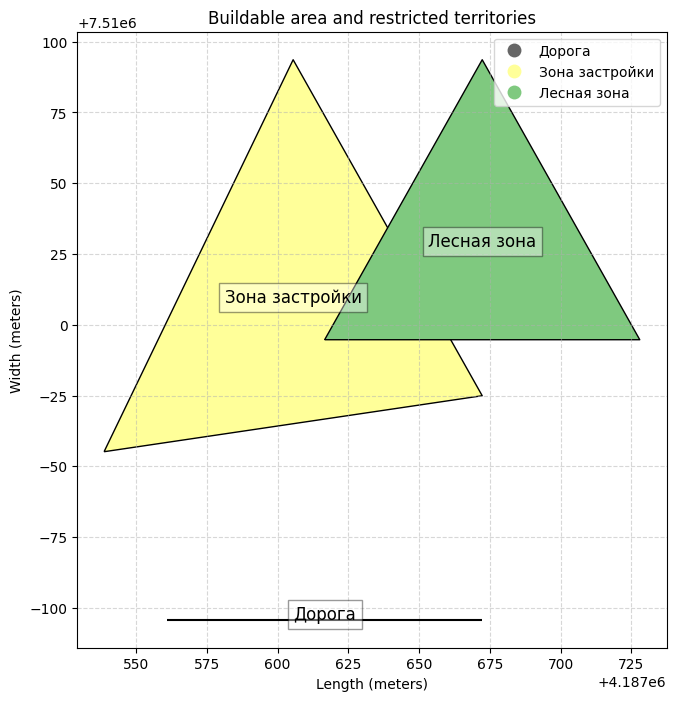

In [ ]:
plot_territory(gdf_large)

# Get the area where it is allowed to build
This part of the project separates the area where it is allowed to build from the initial territory. In the cases when the restricted road crosses the buildable area, the function creates a buffer around the road so that it is impossible to build on it.

In [ ]:
def get_buildable_area(gdf, road_buffer=2, road_width=10, border_offset=2):
    """
    Defines the buildable area excluding restricted zones using unary union and difference
    and prints the area, length and width of the buildable area.

    Args:
        gdf (gdp.GeoDataFrame): the initial area with restrictions and bulding zones.
        road_buffer (int or float): buffer size around the restricted road in meters.
        Needed when the restricted road crosses the buildable area (default is 2 meters).
        road_width (int or float): width of the restricted road in meters (default is 10 meters).
        border_offset (int or float): minimum distance from future buildings
        to the buildable area boundary in meters (default is 2 meters).

    Returns:
        shapely.geometry.Polygon: polygon for bulding.
    """
    # This geodataframe contains all polygons that are not restricted for building
    not_restricted = gdf[(gdf.geometry.type == 'Polygon') &
                         (~gdf['restriction'].isin(['no_build']))
    ]

    # This geodataframe contains all polygons and lines that are restricted for building
    restricted = gdf[gdf['restriction'].isin(['no_build'])
    ]

    # Unites all not restricted polygons into one polygon
    not_restricted_union = unary_union(not_restricted.geometry)

    # Gets all LineString objects (roads) from the territory
    roads = gdf[gdf.geometry.type == 'LineString']

    # Creates a buffer around those roads (including the actual width of the roads)
    roads_buffered = roads.buffer(road_buffer + road_width * 0.5)

    # Unites all restricted polygons into one polygon
    all_restricted = pd.concat([restricted.geometry, roads_buffered])
    restricted_union = unary_union(all_restricted)

    # Removes restricted area from the building zone if there is any
    buildable_area = not_restricted_union.difference(restricted_union)

    # Creates a buffer from inside the borders of the buildable area
    # using minimum distance from future building site to the buildable area borders
    # Removes that buffered borders from the buildable area
    buildable_area = buildable_area.buffer(-border_offset)

    xmin, ymin, xmax, ymax = buildable_area.bounds
    print(
    f"The area is {round(buildable_area.area, 3)} square meters\n"
    f"The length is {round(xmax-xmin, 3)} meters, "
    f"the width is {round(ymax-ymin, 3)} meters"
    )

    return buildable_area

The area is 2213010.672 square meters
The length is 1927.673 meters, the width is 1562.113 meters


<Axes: >

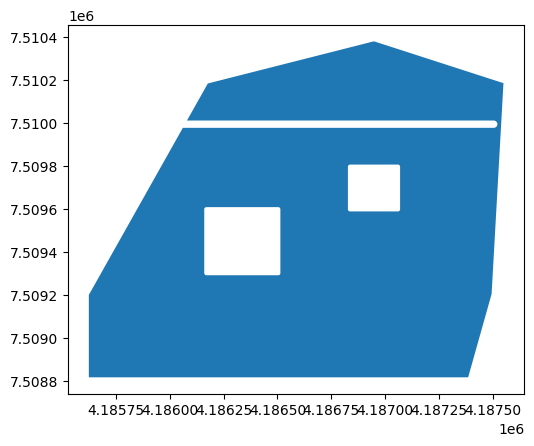

In [ ]:
buildable_area_large = get_buildable_area(gdf_large, border_offset=10)
gpd.GeoSeries([buildable_area_large]).plot()

# Build the roads
**build_roads** generates a road network within the buildable area.
 It creates a grid of roads (vertical and horizontal) using the specified space between roads.

 The grid of roads was chosen because it covers the entire buildable area with a predictable pattern that ensures that all parts of the area have road access. Also, this method is easily adjustable through the function parameters.





In [ ]:
def build_roads(buildable_area, road_width=4, spacing_x=100, spacing_y=100, v=2, h=1):
    """
    Generates road network (grid) within the buildable area using the specified road parameters
    and then plots the buildable area with roads.

    Args:
        buildable_area (shapely.geometry.Polygon): polygon for building.
        road_width (int): road width in meters (default is 4 meters).
        spacing_x (int): the distance between horizontal roads (not including road width) in meters (default is 100 meters).
        spacing_y (int): the distance between vertical roads (not including road width) in meters (default is 100 meters).
        v (int): vertical road frequency coefficient. The smaller it is, the more frequent the vertical roads are.
        h (int): horizontal road frequency coefficient. The smaller it is, the more frequent the horizontal roads are.
    h and v provide an additional adjustability of the road grid.

    Returns:
        list[shapely.geometry.LineString]: list of the roads within the buildable area.
    """
    # Coordinates of the bounds of the buildable area
    x_min, y_min, x_max, y_max = buildable_area.bounds
    roads = []

    # Creates a road grid with a step of (width + spacing) * coefficient
    for x in range(int(x_min), int(x_max), v * (road_width + spacing_y)):
        road = LineString([(x, y_min), (x, y_max)])
        # Removes those parts of the road that are outside the buildable area
        clipped_road = road.intersection(buildable_area)
        if not clipped_road.is_empty:
            roads.append(clipped_road)

    # Creates a road grid with a step of (width + spacing) * coefficient
    for y in range(int(y_min), int(y_max), h * (road_width + spacing_x)):
        road = LineString([(x_min, y), (x_max, y)])
        # Removes those parts of the road that are outside the buildable area
        clipped_road = road.intersection(buildable_area)
        if not clipped_road.is_empty:
            roads.append(clipped_road)

    # Plot the roads within the buildable area
    fig, ax = plt.subplots(figsize=(8, 8))
    gpd.GeoSeries([buildable_area]).plot(ax=ax, color='lightgray', edgecolor='black', alpha=1)
    gpd.GeoSeries(roads).plot(ax=ax, color='black', linewidth=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.show()

    return roads

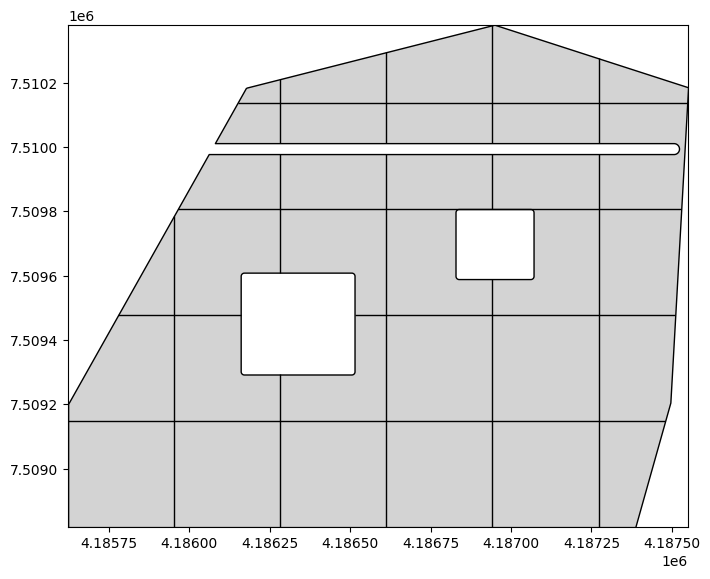

In [ ]:
roads_large = build_roads(buildable_area_large, road_width=10, h=3, v=3)

# Build zones
This code automatically allocates urban zones (buildings, commercial buildings and parks) within the buildable area.

**random_point_in_polygon** generates a random point within a polygon, ensuring that it lies fully inside that polygon.

**build_zones** takes the remaining  area (after roads are subtracted) and repeatedly attempts to place new polygons with random length and width (within some range). Those polygons represent buildings, commercial areas or parks.

For small areas, the function has a limit of only one park. For larger areas, there is a rule: one park per four buildings. The code also checks if commercial buildings are allowed or not on the area. If they are allowed, there is also a rule: one commercial building per three buildings.

When creating each new zone (polygon), the algorithm picks a random center using **random_point_in_polygon**, determines a random size, and checks that the resulting polygon is fully inside the buildable area and does not intersect other objects.
If placing an object fails too many times, the size of the future building decreases, and placing a new polygon starts all over again.

**plot_zones** plots the buildable area, the roads (taking into account their width), and the buildings, commercial areas, and parks in different colors.

In [ ]:
def random_point_in_polygon(polygon, attempts=100):
    """
    Chooses a random point within the specified polygon.
    If no suitable point is found for the specified number of attempts,
    it returns None.

    Args:
      polygon (shapely.geometry.Polygon): polygon within which the random point is being computed.
      attempts (int): number of attempts to find a point (default is 100).

    Returns:
        None
    """
    x_min, y_min, x_max, y_max = polygon.bounds

    for _ in range(attempts):
        # Creates a point with coordinates that are random and uniformly distributed within the bounds
        point = Point(random.uniform(x_min, x_max), random.uniform(y_min, y_max))
        if point.within(polygon):
            return point
    return None

In [ ]:
def build_zones(buildable_area, roads,
                density=0.6,
                min_distance=2,
                road_offset=2,
                min_size=10,
                max_size=20,
                road_width=4,
                commercials_allowed=False
                ):
    """
    Places buildings, commercial areas and parks within the buildable area taking into account roads,
    density, minimal distance, etc.

    Buildings: residential and public buildings like apartment buildings, schools, etc.

    Commercials: commercial buildings like shopping malls, restaurants, etc.

    Parks: green zones like parks or botanical gardens.


    Args:
        buildable_area (shapely.geometry.Polygon): polygon for building.
        roads (list[shapely.geometry.LineString]): list of all roads.
        density (float): the percentage of the land area allowed for development (0-1) (default is 0.6).
        min_distance (int or float): minimal distance between objects (polygons) in meters (default is 2 meters).
        road_offset (int or float): minimal distance between roads and polygons in meters (default is 2 meters).
        min_size (int): minimal possible length or width of a polygon in meters (default is 10 meters).
        max_size (int): maximal possible length or width of a polygon in meters (default is 20 meters).
        road_width (int): road width in meters (default is 4 meters).
        commercials_allowed (bool): if set to False, the algorithm will never place any commercial zones.

    Returns:
         dict: {'buildings': list[Polygon], 'commercials': list[Polygon], 'parks': list[Polygon]}
         All zones divided into categories
    """
    # Determines the length and width of the bounds of the buildable area
    x_min, y_min, x_max, y_max = buildable_area.bounds
    width = x_max - x_min
    height = y_max - y_min
    area = buildable_area.area
    # If both the width and height are less than 500 m, area is less than 8000 square meters,
    # the buildable area is considered small
    small_area = (width <= 500 and height <= 500) and area <= 8000

    print(f"Area: {buildable_area.area:.2f} square meters")
    print(f"Width: {width:.2f} meters, length: {height:.2f} meters")

    # Lists to store buildings, commercials, and parks.
    buildings = []
    commercials = []
    parks = []

    # Unite all roads
    all_roads = unary_union(roads)

    # Create a road buffer around all roads united taking road_offset and road_width into account
    road_buffer = all_roads.buffer(road_offset + road_width * 0.5)

    # Remove roads with their buffers in order not to put a building on them
    buildable_area = buildable_area.difference(road_buffer)

    # Determines the allowed part of the buildable area
    area_to_build = buildable_area.area * density

    # Tracks the amount of area occupied at each step of building.
    current_built_area = 0

    # Spatial index for fast intersection checks
    spatial_index = index.Index()
    object_list = []

    # Maximal number of fails allowed
    max_fails = 500
    # Track the number of fails if it fails to place a polygon
    fails = 0
    # Track the number of general iterations
    total_iterations = 0
    # General iterations limit
    max_iter = 10000

    # Current maximal size of a wall of a polygon (gets smaller if fails to be placed)
    current_max_size = max_size

    while current_built_area < area_to_build and total_iterations < max_iter:

        total_iterations += 1

        # If the area is small, we need one park in it
        if small_area:
            # If there is still no park
            if len(parks) < 1:
                # If the number of buildings is not enough to match
                # the rule "1 commercial per 3 buildings", then choose building
                if len(buildings) < len(commercials) * 4:
                    zone_type = 'building'
                else:
                    # If there are enough buildings, choose park
                    zone_type = 'park'
            else:
                # If there is already one park, choose among commercials and buildings
                # according to the rule "1 commercial per 3 buildings"
                if len(buildings) < len(commercials) * 4:
                    zone_type = 'building'
                else:
                    zone_type = 'commercial'
        else:
            # For big areas: 1 park per 4 buildings
            if len(buildings) < len(commercials) * 4:
                zone_type = 'building'
            elif len(parks) < len(buildings) // 4:
                zone_type = 'park'
            else:
                zone_type = 'commercial'

        # If commercial_allowed == False, then we never choose commercials
        if not commercials_allowed and zone_type == 'commercial':
            zone_type = 'building'

        # Get random uniformly distributed integer sizes of the new object
        length = random.randint(min_size, current_max_size)
        width = random.randint(min_size, current_max_size)

        # Get a random point that will be the center of the future object
        center = random_point_in_polygon(buildable_area)
        if center is None:
            # Did not manage to find a point within the area
            fails += 1
            if fails > max_fails:
                # Exceeded the allowed number of fails, leave this object
                break
            continue

        # If the point is found, create a polygon centered at this point
        x0, y0 = center.x - width/2, center.y - length/2
        new_object = Polygon([
            (x0, y0), # bottom-left corner
            (x0 + width, y0), # bottom-right
            (x0 + width, y0 + length), # top-right
            (x0, y0 + length) # top-left
        ])

        # Check that the object is inside the buildable area
        if not new_object.within(buildable_area):
            fails += 1
            if fails > max_fails:
                # If exceeded the allowed number of fails, decrease the maximal size of a wall
                current_max_size = max(current_max_size - 1, min_size)
                fails = 0  # reset the counter and try with a smaller wall size
            continue

        # Check that the object doesn't intersects other buildings + their buffers
        buffer = new_object.buffer(min_distance)
        intersecting = any(object_list[i].intersects(buffer)
                           for i in spatial_index.intersection(buffer.bounds))

        if intersecting:
            fails += 1
            if fails > max_fails:
                # If exceeded the allowed number of fails, decrease the maximal size of a wall
                current_max_size = max(current_max_size - 1, min_size)
                fails = 0
            continue

        # Additional check for parks:
        # if the area is not small, the distance between parks should be at least 120 meters
        if zone_type == 'park' and not small_area:
            too_close_to_park = any(new_object.distance(park) < 120 for park in parks)
            if too_close_to_park:
                zone_type = 'building'
                fails += 1
                if fails > max_fails:
                    current_max_size = max(current_max_size - 1, min_size)
                    fails = 0
                continue

        # If everything is good, place the polygon
        idx = len(object_list)
        spatial_index.insert(idx, new_object.bounds)
        object_list.append(new_object)
        current_built_area += new_object.area
        fails = 0

        # Add the new polygon to the corresponding list
        if zone_type == 'building':
            buildings.append(new_object)
        elif zone_type == 'commercial':
            commercials.append(new_object)
        else:
            parks.append(new_object)

    return {
        'buildings': buildings,
        'commercials': commercials,
        'parks': parks
    }

In [ ]:
def plot_zones(buildable_area, roads,
               buildings, commercials,
               parks, road_width=4
               ):
   """
   Plots the buildable area with its roads and zones.

   Args:
        buildable_area (shapely.geometry.Polygon): polygon for building.
        roads (list[shapely.geometry.LineString]): list of all roads.
        buildings (list[shapely.geometry.Polygon]): list of buildings (residential and public).
        commercials (list[shapely.geometry.Polygon]): list of commercial buildings.
        parks (list[shapely.geometry.Polygon]): list of parks.
        road_width (int): road width in meters (default is 4 meters).
   """
   fig, ax = plt.subplots(figsize=(8,8))

    # Plots the buildable area
   gpd.GeoSeries([buildable_area]).plot(
        ax=ax, color='lightgray', edgecolor='black', alpha=1, label='Buildable Area'
    )

   # Unite all roads taking their width into account
   roads_union = unary_union(roads)
   roads_buffered = roads_union.buffer(road_width / 2)

   # Plot the roads with their width
   gpd.GeoSeries([roads_buffered]).plot(
        ax=ax, color='black', alpha=0.7
    )

   # Plot the zones.
   gpd.GeoSeries(buildings).plot(ax=ax, color='blue', alpha=0.7, label='Building')
   gpd.GeoSeries(commercials).plot(ax=ax, color='red', alpha=0.7, label='Commercial')
   gpd.GeoSeries(parks).plot(ax=ax, color='green', alpha=0.7, label='Parks')

   plt.legend()
   plt.title("Zones on the buildable area")
   plt.show()


Area: 2213010.67 square meters
Width: 1927.67 meters, length: 1562.11 meters


<ipython-input-23-629bebe10957>:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
<ipython-input-23-629bebe10957>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


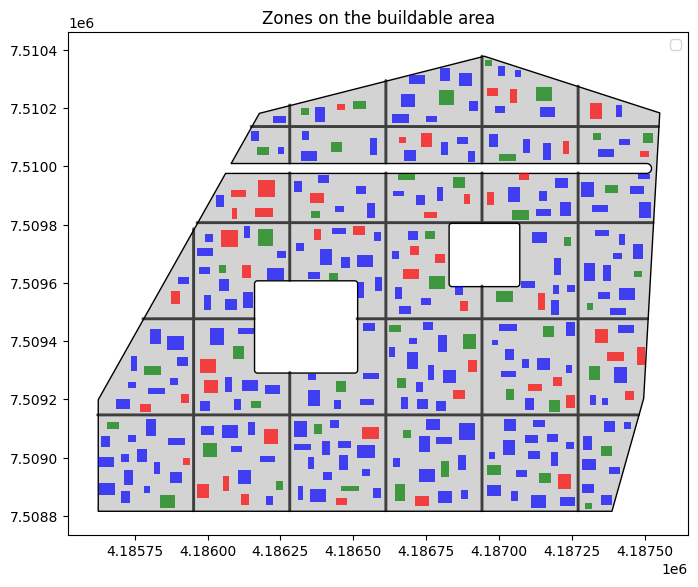

In [ ]:
zones_large = build_zones(buildable_area_large, roads_large,
                        density=0.6, min_distance=20,
                        road_offset=7, min_size=20,
                        max_size=60, road_width=6,
                        commercials_allowed=True)

plot_zones(buildable_area_large, roads_large,
           zones_large['buildings'],
           zones_large['commercials'],
           zones_large['parks'],
           road_width=10
           )

# Build public transportation stops

Here, public transportation stops are placed considering the minimal allowed distance to road intersections, distance between stops and distance from buildings to stops. This part consists of 4 functions:

**find_road_intersections**: finds all the points that are intersections of the roads.

**generate_stops_big_area**: builds stops on each road with a specified stop distance. Takes into account distance to road intersections and distance from buildings to stops.

**build_stops**: the main function that checks the size of the buildable area, and if it is not considered small, calls the function **generate_stops_big_area**.

**plot_stops**: plots the buildable area, the roads, the buildings, commercial areas, parks, and stops.

In [ ]:
def find_road_intersections(roads):

    """
    Finds all the points that are intersections of the roads.

    Args:
       roads (list[shapely.geometry.LineString]): list of the roads within the buildable area.

    Returns:
        list[shapely.geometry.Point]: list of all intersection points.
    """
    intersections = []
    for i in range(len(roads)):
        for j in range(i+1, len(roads)):
            inter = roads[i].intersection(roads[j]) # intersection point of 2 roads
            if not inter.is_empty:
                # If that intersection is one point
                if inter.geom_type == 'Point':
                    intersections.append(inter)
                # If that intersection is several points
                elif inter.geom_type == 'MultiPoint':
                    intersections.extend(list(inter.geoms))

    return intersections

In [ ]:
def generate_stops_big_area(buildable_area, roads,
                            zones, stops_distance,
                            distance_to_buildings,
                            intersections,
                            min_distance_to_intersections,
                            distance_to_boundary):
    """
    Generates stops for areas that are not considered small. Places stops on each road respecting stops distance,
    distance to buildings and distance to intersections.

    Args:
        buildable_area (shapely.geometry.Polygon): polygon for building.
        roads (list[shapely.geometry.LineString]): list of all roads.
        zones (dict: {'buildings': list[Polygon], 'commercials': list[Polygon], 'parks': list[Polygon]}):
        all polygons on buildable area divided into 3 categories.
        stops_distance (int or float): distance between stops.
        distance_to_buildings (int or float): distance between stops and buildings.
        intersections (list[shapely.geometry.Point]): list of all intersection points.
        min_distance_to_intersections (int or float): minimal allowed distance to intersections.
        distance_to_boundary (int or float): minimal allowed distance to buildable distance boundaries.

    Returns:
        list[shapely.geometry.Point]: list of all stops.
"""
    stops = []
    # All intersections united (so it is easier to calculate the distance to each of them)
    intersections_union = unary_union(intersections) if intersections else None

    # Generates the stops along each road
    for road in roads:
        # Number of stops along each road
        num_stops = int(road.length // stops_distance)
        # Loop through the points along that road
        for i in range(1, num_stops):
            pt = road.interpolate(i * stops_distance) #place stops with the specified distance
            # If the stop is too close to borders
            if pt.distance(buildable_area.boundary) < distance_to_boundary:
                continue
            # If the stop is too close to buildings and parks
            if any(pt.intersects(building.buffer(distance_to_buildings))
                  for zone in zones.values()
                  for building in zone):
                continue
            # If the stop it too close to intersections
            if pt.distance(intersections_union) < min_distance_to_intersections:
                    continue
            # If everything is OK
            stops.append(pt)

    return stops

In [ ]:
def build_stops(buildable_area, roads,
                zones, stops_distance=500,
                min_distance_to_intersections=10,
                distance_to_buildings=10,
                area_length = 500, area_width = 500,
                distance_to_boundary=0):
    """
    The main function that checks the size of the buildable area,
    and if it is not considered small, calls the function generate_stops_big_area.

    Args:
        buildable_area (shapely.geometry.Polygon): polygon for building.
        roads (list[shapely.geometry.LineString]): list of all roads.
        zones (dict: {'buildings': list[Polygon], 'commercials': list[Polygon], 'parks': list[Polygon]}):
        all polygons on buildable area divided into 3 categories.
        stops_distance (int or float): distance between stops in meters (default is 500).
        min_distance_to_intersections (int or float): minimal allowed distance to intersections (default is 10 meters).
        distance_to_buildings (int or float): distance between stops and buildings in meters (default is 10).
        area length (int or float): length of the buuildable_area.bounds (default is 500 meters).
        area width (int or float): width of the buuildable_area.bounds (default is 500 meters).
        distance_to_boundary (int or float): minimal allowed distance to buildable distance boundaries.
        Default is 0 meters because we already removed the borders with the buffer in get_buildable_area.

    Returns:
        list[shapely.geometry.Point]: list of all stops.

    """
    # Calculates the size of buildable area
    x_min, y_min, x_max, y_max = buildable_area.bounds
    width = x_max - x_min
    height = y_max - y_min
    small_area = width <= area_width and height <= area_length

    # Gets intersection points
    intersections = find_road_intersections(roads)

    # If the area is considered small, we cannot build stops
    if small_area:
        print(f'height: {height}, width: {width}.\nThe area is considered too small to build stops.')
        return None

    # If the area is not small, calls generate_stops_big_area
    print(f'height: {height}, width: {width}.\nThe area is considered not small.')
    stops = generate_stops_big_area(buildable_area, roads,
                                    zones, stops_distance,
                                    distance_to_buildings,
                                    intersections,
                                    min_distance_to_intersections,
                                    distance_to_boundary
                                   )

    return stops

In [ ]:
def plot_stops(buildable_area, roads, zones, stops):
    """
    Plots the buildable area with its roads, zones and stops.

   Args:
        buildable_area (shapely.geometry.Polygon): polygon for building.
        roads (list[shapely.geometry.LineString]): list of all roads.
        zones (dict: {'buildings': list[Polygon], 'commercials': list[Polygon], 'parks': list[Polygon]}):
        all zones divided into categories.
        stops (list[shapely.geometry.Point]): list of all stops.
    """
    x_min, y_min, x_max, y_max = buildable_area.bounds
    width = x_max - x_min
    height = y_max - y_min

    # If the area is considered small, it doesn't have stops, therefore no plots
    if  stops is not None:
        fig, ax = plt.subplots(figsize=(8, 8))

        # Plot buildable area
        gpd.GeoSeries([buildable_area]).plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='Buildable area')

        # Plot roads
        gpd.GeoSeries(roads).plot(ax=ax, color='gray', linewidth=2, label='Roads')

        # Plot zones
        if 'buildings' in zones and zones['buildings']:
            gpd.GeoSeries(zones['buildings']).plot(ax=ax, color='blue', alpha=0.5, label='Buildings')
        if 'commercials' in zones and zones['commercials']:
            gpd.GeoSeries(zones['commercials']).plot(ax=ax, color='red', alpha=0.5, label='Commercials')
        if 'parks' in zones and zones['parks']:
            gpd.GeoSeries(zones['parks']).plot(ax=ax, color='green', alpha=0.5, label='Parks')

        # Plot stops
        if stops:
            stops_gs = gpd.GeoSeries(stops)
            stops_gs.plot(ax=ax, color='red', marker='o', markersize=20, label='Stops')

        plt.legend()

        plt.title("Buildable area with roads, zones and stops")
        plt.xlabel("X (meters)")
        plt.ylabel("Y (meters)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

In [ ]:
stops_triangle = build_stops(buildable_area_triangle, roads_triangle,
                        zones_triangle, stops_distance=100,
                        min_distance_to_intersections=4,
                        distance_to_buildings=5)
plot_stops(buildable_area_triangle, roads_triangle, zones_triangle, stops_triangle)

height: 131.62546618841588, width: 126.97334087593481.
The area is considered too small to build stops.


# Get output geojson file and plan picture.


In [ ]:
def output_geojson(zones, roads, stops, output_path="output.geojson"):
    """
    Generates a geojson file with coordinated of buildings, commercials, parks, roads and stops.

    Args:
        zones (dict: {'buildings': list[Polygon], 'commercials': list[Polygon], 'parks': list[Polygon]}):
        all polygons on buildable area divided into 3 categories.
        roads (list[shapely.geometry.LineString]): list of all roads.
        stops ( list[shapely.geometry.Point]): list of all stops.
        output_path (str): output geojson file path.
    """

    features = []

    # Add buildings
    for building in zones.get('buildings', []):
        feature = {
            "type": "Feature",
            "properties": {"type": "building"},
            "geometry": mapping(building)
        }
        features.append(feature)

    # Adds commercials
    for commercial in zones.get('commercials', []):
        feature = {
            "type": "Feature",
            "properties": {"type": "commercial"},
            "geometry": mapping(commercial)
        }
        features.append(feature)

    # Adds parks
    for park in zones.get('parks', []):
        feature = {
            "type": "Feature",
            "properties": {"type": "park"},
            "geometry": mapping(park)
        }
        features.append(feature)

    # Adds roads
    for road in roads:
        feature = {
            "type": "Feature",
            "properties": {"type": "road"},
            "geometry": mapping(road)
        }
        features.append(feature)

    # Adds stops
    if stops:
        for stop in stops:
            feature = {
                "type": "Feature",
                "properties": {"type": "stop"},
                "geometry": mapping(stop)
            }
            features.append(feature)

    geojson_data = {
        "type": "FeatureCollection",
        "features": features
    }

    with open(output_path, 'w') as f:
        json.dump(geojson_data, f, indent=2)

    print(f"The file is saved to {output_path}")

In [ ]:
output_geojson(zones_large, roads_large, stops_large, output_path="plan_large.geojson")

The file is saved to plan_large.geojson


In [ ]:
output_gdf = load_geojson('plan_large.geojson', epsg_code=4326)

In [ ]:
def save_plan_image(gdf, buildable_area,
                    roads,
                    zones, stops=[],
                    road_width=4,
                    output_image="plan.png"):
    """
    Plots the plan of the territory and saves the image to output_image (.png)

    Args:
        gdf (gdp.GeoDataFrame): the initial area with restrictions and bulding zones.
        buildable_area (shapely.geometry.Polygon): polygon for building.
        roads (list[shapely.geometry.LineString]): list of all roads.
        zones (dict: {'buildings': list[Polygon], 'commercials': list[Polygon], 'parks': list[Polygon]}):
        all polygons on buildable area divided into 3 categories.
        stops (list[shapely.geometry.Point]): list of all stops (default is empty).
        road_width (int): width of the roads in meters (default is 4 meters).
        output_image (str): output image path.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the initial territory
    gdf.plot(ax=ax, color='whitesmoke', edgecolor='black', alpha=0.5,
             label='Initial territory', zorder=1)

    # Divide objects into restricted and not restricted (buildable area)
    if "restriction" in gdf.columns:
        restricted_gdf = gdf[gdf['restriction'].isin(['no_build'])]
        allowed_gdf = gdf[~gdf['restriction'].isin(['no_build'])]

    # Plot the initial buildable area
    if not allowed_gdf.empty:
        allowed_gdf.plot(ax=ax, color='gray', edgecolor='gray', alpha=0.5,
                         label='Buildable area', zorder=2)

    # Plot the restricted polygons
    restricted_polygons = restricted_gdf[restricted_gdf.geometry.type == "Polygon"]
    if not restricted_polygons.empty:
        restricted_polygons.plot(ax=ax, color='orange', edgecolor='red', alpha=0.4,
                                 label='Restricted polygons', zorder=2)
        for idx, row in restricted_polygons.iterrows():
            centroid = row.geometry.centroid
            name_str = row["name"] if pd.notnull(row.get("name", None)) else "No name"
            ax.text(centroid.x, centroid.y,
                    f"{name_str}\n({row['restriction']})",
                    fontsize=9, ha="center",
                    bbox=dict(facecolor='white', alpha=0.5),
                    zorder=3)

    # Plot the restricted roads
    restricted_lines = restricted_gdf[restricted_gdf.geometry.type == "LineString"]
    if not restricted_lines.empty:
        restricted_lines.plot(ax=ax, color='red', linewidth=2,
                              label='Roads (restricted)', zorder=2)

    # Plot the final buildable area
    if buildable_area is not None and not buildable_area.is_empty:
        gpd.GeoSeries([buildable_area]).plot(
            ax=ax, color='none', edgecolor='black', linewidth=2,
            label='Final buildable area', zorder=3
        )

    # Plot the built roads
    if roads:
        roads_union = unary_union(roads)
        roads_buffered = roads_union.buffer(road_width / 2)
        gpd.GeoSeries(roads).plot(ax=ax, color='gray', linewidth=1,
                                  label='Built roads', zorder=4)

    # Plot the roads considering their width
    gpd.GeoSeries([roads_buffered]).plot(
        ax=ax, color='black', alpha=1., label='Roads'
    )

    # Plot all the zones
    if 'buildings' in zones and zones['buildings']:
        gpd.GeoSeries(zones['buildings']).plot(ax=ax, color='blue', alpha=0.5,
                                               zorder=5)
    if 'commercials' in zones and zones['commercials']:
        gpd.GeoSeries(zones['commercials']).plot(ax=ax, color='red', alpha=0.5,
                                                zorder=5)
    if 'parks' in zones and zones['parks']:
        gpd.GeoSeries(zones['parks']).plot(ax=ax, color='green', alpha=0.5,
                                           zorder=5)

    # Plot the stops
    if stops:
        gpd.GeoSeries(stops).plot(ax=ax, color='purple', alpha=0.5, marker='o', markersize=20,
                                  zorder=6)

    legend_items = []
    legend_items.append(mpatches.Patch(facecolor='orange', edgecolor='red', alpha=0.4, label='Restricted zones'))
    legend_items.append(mlines.Line2D([], [], color='red', linewidth=2, label='Restricted road'))
    legend_items.append(mpatches.Patch(color='gray', label='Buildable area'))
    legend_items.append(mlines.Line2D([], [], color='gray', linewidth=2, label='Built roads'))
    legend_items.append(mpatches.Patch(color='blue', alpha=0.5, label='Residential and public buildings'))
    legend_items.append(mpatches.Patch(color='green', alpha=0.5, label='Parks'))

    if 'commercials' in zones and zones['commercials']:
        legend_items.append(mpatches.Patch(color='red', alpha=0.5, label='Commercial buildings'))

    if stops:
        legend_items.append(mlines.Line2D([], [], color='purple', marker='o', linestyle='None', markersize=10,
                                          label='Public transportation stops'))

    # Place the legend a little to the right so it does not cover the plan
    ax.legend(
    handles=legend_items,
    loc='upper right',
    bbox_to_anchor=(1.2, 1.2),
    borderaxespad=0
)

    ax.set_aspect('equal', 'box')
    plt.title("The final building plan")
    plt.xlabel("X (meters)")
    plt.ylabel("Y (meters)")
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(output_image, dpi=300)
    plt.show()
    print(f"The image is saved to {output_image}")

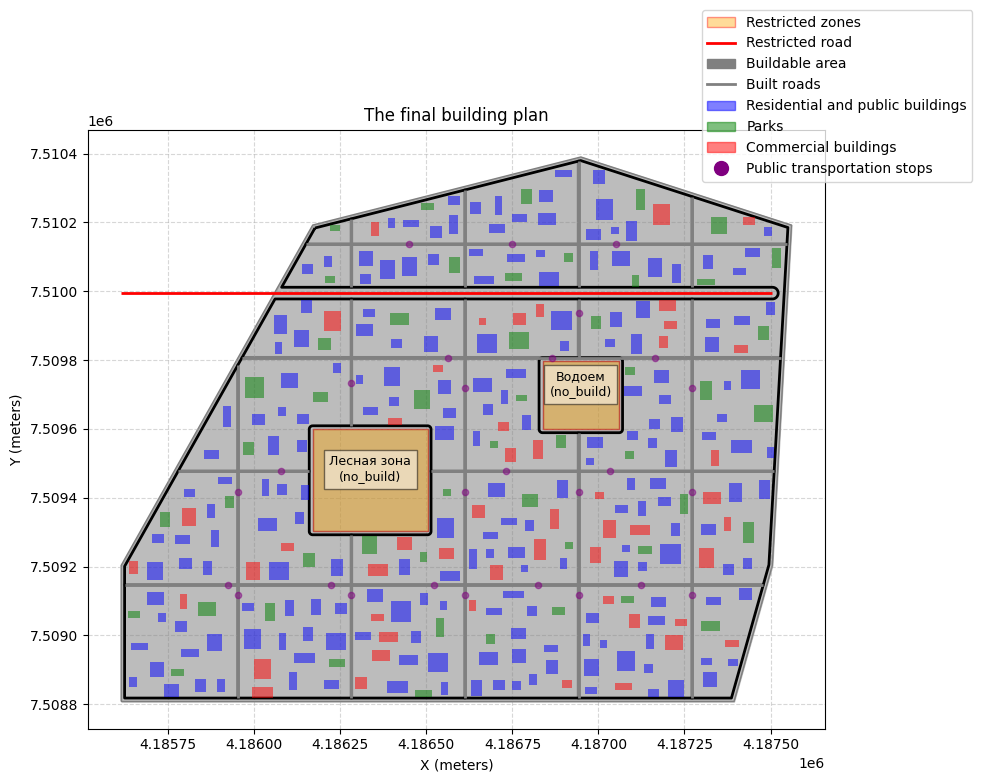

The image is saved to plan_large.png


In [ ]:
save_plan_image(gdf_large, buildable_area_large,
                roads_large, zones_large,
                stops_large, road_width=10,
                output_image='plan_large.png')

# Future work:

1. based on the area of the building zone, develop different road widths: develop highways, main roads and local roads, change road spacing within one buildable area.

2. based on the purpose of the building zone, make road spacing more frequent (for residential areas) or rarer (for industrial areas).

3. build stops even for smaller buildable areas according to the following rules: the stops should be close to the borders of the buildable area, but only to those borders that are not adjacent to the restricted zones (water, forest, etc.). The idea is that the buildable area is probably a district within a city or a town. So at least it should have stops close to the borders so people can get there from other parts of the city by public transportation. Hovewer, the stops are not needed inside the building area because it's so small that people can navigate on foot.

4. divide public and residential buildings into 2 separate categories, not have them as one category. Then, divide the public buldings into schools, hospitals, universities, theaters, etc.

5. also, divide commercial buildings into shopping zones, banks, entertainment (restaurants, bars, bowling, etc.).

6. the areas of the parks should be proportional to the sum of the areas of the residential buildings. The idea is that often, the larger is the area of the residetial buildings, the more people live in them, therefore, the bigger the parks should be in that vicinity.